# import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint,sample,random as rnd
import networkx as nx
from tqdm.autonotebook import tqdm
from scipy.stats import linregress
from time import time as timer
from bottleneck import move_mean
from joblib import Parallel,delayed,cpu_count
njobs = int(cpu_count()*0.75)
print(f"Using {njobs} cores out of {cpu_count()} ")

/tmp/ipykernel_2762977/4252282145.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Using 18 cores out of 24 


In [2]:
from networklib import *

ModuleNotFoundError: No module named 'networklib'

In [3]:
def raise_error_network(n,m,func_name):
    if n <=0 :
        print(f"n must be positive number in "+func_name)
        return True
    elif m <= 0:
        print(f"m must be positive number in "+func_name)
        return True
    elif m >= n:
        print(f"m must be lower than n in "+func_name)
        return True
#%%
def histo_int(z,nbins=None,logbins=True,density=True,return_log_linregress=True,start_end_fit=None):
    if logbins:
        if nbins is None:
            nbins = 50
        xbins = np.unique(np.logspace(0,np.log10(z.max()+2),nbins).astype(int))
    else:
        xbins = np.arange(z.min(),z.max()+2)
    y = np.histogram(z,xbins,density=density)[0]
    nz = y!=0
    if return_log_linregress:
        x = xbins[:-1][nz]
        y = y[nz]
        x_log = np.log(x)
        y_log = np.log(y)
        # N = len(x)
        # D = np.zeros(N)
        # for st in range(N):
        #     landa = 1 + N/(np.log(x/(st-0.5)).sum())
        #     slope = linregress(x_log[st:],y_log[st:]).slop
        try:
            if len(start_end_fit) == 1:
                st = start_end_fit
                en = len(x)
            elif len(start_end_fit) == 2:
                st,en = start_end_fit
            else:
                st = 0
                en = len(x)
        except:
            st = 0
            en = len(x)
        return x,y,linregress(np.log(x[st:en]),np.log(y[st:en]))
    
    else:
        return xbins[:-1][nz],y[nz]
def histo_list(Z,nbins=50,logbins=True,density=True,nonezero=True):
    zmax = max([z.max() for z in Z])+2
    zmin = min([z.min() for z in Z])
    if logbins:
        if zmin < 1:
            zmin = 0
        else:
            zmin = np.log10(zmin)
        xbins = np.unique(np.logspace(zmin,np.log10(zmax),nbins).astype(int))
    else:
        xbins = np.arange(zmin,zmax)
    Y = [np.histogram(z,xbins,density=density)[0] for z in Z]
    x = xbins[:-1]
    if nonezero:
        X = [x[y!=0] for y in Y]
        Y = [y[y!=0] for y in Y]
        return X,Y
    return [x]*len(Z),Y
#%%
def calculate_L_wonx(neiz,n=None):
    if n is None:
        n = len(neiz)
    L = np.zeros(n,int)
    for i in np.arange(n):
        a = set(neiz[i])
        if len(a) == 0:
            continue
        for j in a:
            L[i] += len(a.intersection(neiz[j]))
    return L
def calculate_L_sub_wonx(neiz,sub):
    L = []
    for i in sub:
        a = set(neiz[i])
        L.append(0)
        if len(a) == 0:
            continue
        L[-1] = sum([len((a.intersection(neiz[j]))) for j in a])
        # for j in a:
            # L[-1] += len((a.intersection(neiz[j])))
    return L
def cluster_coefs(degree,neiz,return_only_mean=False,n=None):
    if n is None:
        n = len(degree)
    wh = degree>1
    c = calculate_L_wonx(neiz,n)
    if return_only_mean:
        return (c/(degree*(degree-1))).mean() if wh.all() else (c[wh]/(degree[wh]*(degree[wh]-1))).mean()
    else:
        return c/(degree*(degree-1)) if wh.all() else c[wh]/(degree[wh]*(degree[wh]-1))
def cluster_coefs_sub(degree,neiz,sub):
    c = calculate_L_sub_wonx(neiz,sub)
    wh = degree > 1
    if wh.all():
        return c/(degree*(degree-1))
    else:
        c[wh] = c[wh]/(degree[wh]*(degree[wh]-1))
        return c
#%%
def complete_graph_neizonly(n,number_of_empty_nodes=0):
    if n<=0:
        print(f"ERROR: n must be positive number in "+complete_graph_neizonly.__name__)
        return []
    if number_of_empty_nodes>0:
        nrange = list(np.arange(n))
        return [nrange[:i]+nrange[i+1:] for i in range(n-number_of_empty_nodes)]+[[] for i in range(number_of_empty_nodes)]
    else:
        nrange = list(np.arange(n))
        return [nrange[:i]+nrange[i+1:] for i in range(n)]
def complete_graph(n,number_of_empty_nodes=0,return_degree=True,return_L=True,return_clustcoef=False,return_adj=False):
    if n<=0:
        print(f"ERROR: n must be positive number in "+complete_graph.__name__)
        return []
    r = [complete_graph_neizonly(n-number_of_empty_nodes,number_of_empty_nodes)]
    if number_of_empty_nodes>0:
        m = n-number_of_empty_nodes
        if return_degree:
            r.append(np.zeros(n,int))
            r[-1][:m] = m-1
        if return_L:
            r.append(np.zeros(n,int))
            r[-1][:m] = m*(m-1)
        if return_clustcoef:
            r.append(np.zeros(n))
            r[-1][:m] = 1
        if return_adj:
            r.append(np.zeros((n,n),bool))
            r[-1][:m,:m] = True
            r[-1][:m,:m][np.diag_indices(m)] = False
    else:
        if return_degree:
            r.append(np.full(n,n-1,int))
        if return_L:
            r.append(np.full(n,n*(n-1),int))
        if return_clustcoef:
            r.append(np.full(n,1))
        if return_adj:
            r.append(np.ones((n,n),bool))
            r[-1][np.diag_indices(n)] = False
    if len(r) == 1:
        return r[0]
    else:
        return tuple(r)
#%%


# funcs

## BianconiBarbasi

In [4]:
def create_fitness(fitness,fitness_params,n,m=0):
    if isinstance(fitness,np.ndarray):
        if fitness.ndim > 1:
            fitness = fitness.flatten()
        lf = len(fitness)
        if lf == n:
            pass
        elif lf > n:
            fitness = fitness[:n]
        elif lf >= n-m:
            fitness = np.append(np.zeros(n-lf),fitness)
        else:
            fitness = np.append(fitness,np.random.choice(fitness,n-lf,p=np.linspace(1,0.5,lf)/np.linspace(1,0.5,lf).sum(),replace=lf>n//2))
    else:
        if not isinstance(fitness,str):
            fitness = 'uniform'
        if fitness.find('uni') != -1:
            try:
                b = abs(fitness_params[1])
                a = abs(fitness_params[0])
                if a==b:
                    fitness = 1
                elif b < a:
                    a,b = b,a
            except:
                try:
                    a = fitness_params[0]
                    if a <= 0:
                        a,b = 0,1
                    elif a < 0.5:
                        b = 1
                    else:
                        b = a*2
                except:
                    a,b = 1,2
            fitness = np.random.uniform(a,b,n)
        elif fitness.find('norm') != -1 or fitness.find('gaussian') != -1:
            try:
                b = abs(fitness_params[1])
                a = abs(fitness_params[0])
            except:
                try:
                    a = abs(fitness_params[0])
                    if a != 0:
                        b = a/4
                    else:
                        b = 1
                except:
                    a,b = 1,0.25
            fitness = np.abs(np.random.normal(a,b,n))
    return fitness

In [4]:
def BianconiBarbasi_wonx(n=10**4,m=4,fitness=None,fitness_params=None):
    if raise_error_network(n,m,BianconiBarbasi_wonx.__name__):
        return False
    fitness = create_fitness(fitness,fitness_params,n,m)
    neiz = complete_graph_neizonly(m+1,n-m-1)
    degree = np.zeros(n,float)
    degree[:m+1] = m*fitness[:m+1]
    nrange = np.arange(n)
    degree_sum = degree[:m+1].sum()
    for i in range(m+1,n):
        probs = degree[:i]/degree_sum
        tolinks = np.random.choice(nrange[:i],size=m,p=probs,replace=False)
        for j in tolinks:
            neiz[i].append(j)
            neiz[j].append(i)
        added_fitness = fitness[tolinks]
        degree[tolinks] += added_fitness
        degree[i] = m*fitness[i]
        degree_sum += added_fitness.sum()+m*fitness[i]
    return degree,neiz

In [ ]:
# def BianconiBarbasi_grow_wonx(degree=None,neiz=[],L=None,n=10**4,m=4):
#     funcname = BianconiBarbasi_grow_wonx.__name__
#     if raise_error_network(n,m,funcname):
#         return False
#     if neiz is None:
#             neiz,degree = complete_graph(n,n-m-1,return_degree=1,return_L=0)
#             m0 = m
#     else:
#         if len(neiz) > n:
#             print(f"ERROR: new size of network must be grater than old one in {funcname} .")
#             return False
#         if degree is None:
#             degree = [len(nei) for nei in neiz]
#         m0 = len(degree)
#         neiz.extend([[] for i in range(n-m0)])
#         degree = np.append(degree,np.zeros(n-m0,int))
#     degree_sum = degree.sum()
#     nrange = np.arange(n)
#     m2 = m*2
#     for i in range(m0+1,n):
#         probs = degree[:i]/degree_sum
#         tolinks = np.random.choice(nrange[:i],size=m,p=probs,replace=False)
#         for j in tolinks:
#             neiz[i].append(j)
#             neiz[j].append(i)
#         degree[:i][tolinks] += 1
#         degree[i] = m
#         degree_sum += m2
#     return degree,neiz

In [4]:
def BianconiBarbasi_trace_wonx(n=10**4,m=4,fitness=None,fitness_params=None,show_progress=False,NZ=10):
    if raise_error_network(n,m,BianconiBarbasi_trace_wonx.__name__):
        return False
    fitness = create_fitness(fitness,fitness_params,n,m)
    neiz = complete_graph_neizonly(n,n-m-1)
    degree = np.zeros(n)
    degree[:m+1] = m*fitness[:m+1]
    L = np.zeros(n,int)
    L[:m+1] = m*(m-1)
    nrange = np.arange(n)
    degree_sum = degree[:m+1].sum()
    degree_t = np.zeros((n-m-1,n),float)
    if type(NZ) is int:
        NZ = np.linspace(0,n,NZ+1,endpoint=True).astype(int)
        NZ[0] = m+1
    L_t = np.zeros((len(NZ),n),int)
    c = []
    t = 0
    for NZ_i_i,NZ_i in tqdm(enumerate(range(len(NZ)-1)),disable = not show_progress):
        for i in range(NZ[NZ_i],NZ[NZ_i+1]):
            probs = degree[:i]/degree_sum
            # try:
            tolinks = np.random.choice(nrange[:i],size=m,p=probs,replace=False)
            # except:
                # print("AA")
                # return degree[:i],degree_sum,t
            for j in tolinks:
                neiz[i].append(j)
                neiz[j].append(i)
            added_fitness = fitness[tolinks]
            degree[tolinks] += added_fitness
            degree[i] = m*fitness[i]
            degree_sum += added_fitness.sum()+degree[i]
            degree_t[t] = degree
            t += 1
        L_t[NZ_i_i] = calculate_L_wonx(neiz)
        tru_deg = degree/fitness
        tru_deg[fitness==0] = 0
        c.append(L_t[NZ_i_i]/(tru_deg)*(tru_deg-1))
        c[-1][tru_deg<1] = 0
    tru_deg = degree_t/fitness
    tru_deg[:,fitness==0] = 0
    return neiz,degree,c,tru_deg,fitness

In [18]:
def BianconiBarbasi_trace_only_deg_feedfitness(n=10**4,m=4,fitness=None,fitness_params=None,show_progress=False,NZ=10):
    # if raise_error_network(n,m,BianconiBarbasi_trace_only_deg_feedfitness.__name__):
        # return False
    # fitness = create_fitness(fitness,fitness_params,n,m)
    degree = np.zeros(n)
    degree[:m+1] = m*fitness[:m+1]
    nrange = np.arange(n)
    degree_sum = degree[:m+1].sum()
    degree_t = np.zeros((n,n),float)
    t = 0
    for i in tqdm(range(m+1,n),disable = not show_progress):
        probs = degree[:i]/degree_sum
        tolinks = np.random.choice(nrange[:i],size=m,p=probs,replace=False)
        added_fitness = fitness[tolinks]
        degree[tolinks] += added_fitness
        degree[i] = m*fitness[i]
        degree_sum += added_fitness.sum()+degree[i]
        degree_t[:,i] = degree
    tru_deg = degree_t[:,m+1:]/fitness.reshape(-1,1)
    return tru_deg,fitness

In [19]:
r = BianconiBarbasi_trace_wonx(n=10000,fitness_params=[0,1],show_progress=True)

NameError: name 'BianconiBarbasi_trace_wonx' is not defined

In [21]:
st,en = 5,30
x,y,li = histo_int(r[1],start_end_fit=[st,en])

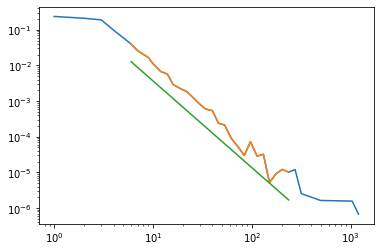

In [22]:
plt.loglog()
plt.plot(x,y)
plt.plot(x[st:en],y[st:en])
plt.plot(x[st:en],x[st:en]**li.slope)

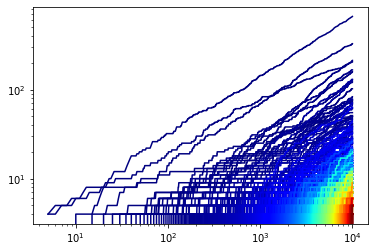

In [10]:
n = len(r[0])
color = [plt.cm.jet(i) for i in np.linspace(0,1,n)]
plt.yscale('log')
plt.xscale('log')
for i in range(0,n,5):
    plt.plot(np.arange(5,n),r[3][:,i],color = color[i])
plt.show()

In [25]:
n = len(r[0])
slopes = np.zeros(n)
xlog = np.log(np.arange(5,n))
nzz = []
for i in range(n//2):
    nz = r[3][:,i]!=0
    if not nz.any():
        nzz.append(i)
    elif len(set(r[3][:,i][nz])) > 0:
        slopes[i] = linregress(xlog[nz],np.log(r[3][:,i][nz])).slope
slope_pos = slopes > 10**-6

In [31]:
print(np.corrcoef(r[-1],np.arange(n))[0,1])
np.corrcoef(r[-1][slope_pos],slopes[slope_pos])[0,1],np.corrcoef((np.arange(len(slopes)))[slope_pos],slopes[slope_pos])[0,1]

-0.008712258811456316


(0.582853508490091, 0.16564211493630127)

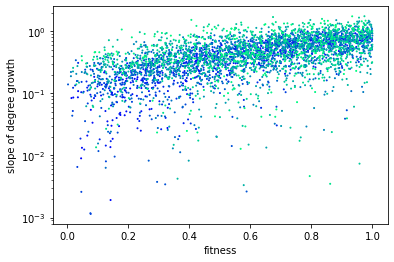

In [30]:
plt.yscale('log')
colors = [plt.cm.winter(i) for i in np.linspace(0,1,(slope_pos).sum())]
plt.scatter(r[-1][slope_pos],slopes[slope_pos],s=1,c=colors)
plt.xlabel("fitness")
plt.ylabel("slope of degree growth")
# plt.ylim(10**-4,None)
plt.show()

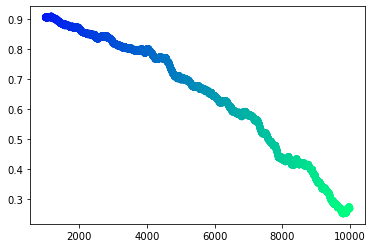

In [104]:
colors = [plt.cm.winter(i) for i in np.linspace(0,1,n)]
plt.scatter(np.arange(n),move_mean(slopes>0,1000),c=colors)

In [21]:
n = 10**4
m = 4
a,b = 0,1
feedfitness = np.random.uniform(a,b,n)
print(feedfitness.min())
feedfitness[feedfitness==0] = feedfitness[feedfitness!=0].min()
print(feedfitness.min())
r = BianconiBarbasi_trace_only_deg_feedfitness(n,m,feedfitness)

5.022244553465338e-05
5.022244553465338e-05


In [14]:
linregress(xlog[nz],np.log(degs[nz])).slope

IndexError: boolean index did not match indexed array along dimension 0; dimension is 10000 but corresponding boolean dimension is 9995

In [36]:
def sloper(n=10000,fitness_params=[0,1]):
    degs,fitness = BianconiBarbasi_trace_only_deg_feedfitness(n=n,fitness_params=fitness_params)
    slopes = np.zeros(n//2)
    xlog = np.log(np.arange(4+1,n//2))
    for i in range(n//2):
            nz = degs[:,i]!=0
            if not nz.any():
                pass
            elif len(set(degs[:,i][nz])) > 0:
                slopes[i] = linregress(xlog[nz],np.log(degs[:,i][nz])).slope
    return slopes,fitness
def sloper_chunk(degs,size,xlog):
    slopes = np.zeros(size)
    for i in range(size):
        nz = degs[i]!=0
        if not nz.any():
            pass
        elif len(set(degs[i][nz])) > 0:
                slopes[i] = linregress(xlog[nz],np.log(degs[i][nz])).slope
    return slopes
def sloper_batcher(degs,njobs=4,xlog=None):
    if xlog is None:
         xlog = np.log(np.arange(n-len(degs[0]),n))
    # xlog = np.log(np.arange(4+1,n//2))
    batch_size = int(len(degs)/njobs)
    return np.array(Parallel(n_jobs=njobs)(delayed(sloper_chunk)(degs[batch_size*i:(i+1)*batch_size],batch_size,xlog) for i in range(njobs))).flatten()
     
     
# sloper_batcher(degs,4)

In [14]:
%%timeit
degsT = degs.T

79.4 ns ± 0.539 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [15]:
%%timeit
degsT = np.transpose(degs)

534 ns ± 0.479 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [13]:
degs,fit = BianconiBarbasi_trace_wonx_only_deg(10**4,fitness=[0,1])
degs = degs.T
n = len(degs)

In [39]:
def sloper(n,feedfitness):
    degs,fitness = BianconiBarbasi_trace_only_deg_feedfitness(n=n,feedfitness=feedfitness)
    slopes = np.zeros(n//2)
    for i in range(n//2):
            nz = degs[:,i]!=0
            if not nz.any():
                pass
            elif len(set(degs[:,i][nz])) > 0:
                slopes[i] = linregress(xlog[nz],np.log(degs[:,i][nz])).slope
    return slopes,fitness
              
n = 10000
xlog = np.log(np.arange(5,n))
njobs = 3
job_banchs = njobs*4
ens = job_banchs*int(100/job_banchs)
print(f"ens={ens}")
n2 = int(0.8*n)
slopes = np.zeros((ens,n2))
fitness = np.zeros((ens,n2))
ens_i = -1
for _ in tqdm(range(ens//job_banchs)):
    r = Parallel(n_jobs=njobs,verbose=False)(delayed(BianconiBarbasi_trace_only_deg_feedfitness)(n=n,fitness=np.random.uniform(0,1,n)) for i in range(job_banchs))
    for j in range(job_banchs):
        ens_i += 1
        degs= r[j][0][:n2]
        fitness[ens_i] = r[j][1][:n2]
        del r[j]
        # degs = degs.T
        # slopes[ens_i] = sloper_batcher(degs[:n//2],4)
        slopes[ens_i] = sloper_batcher(degs[:n2],4,xlog)
        # for i in range(n//2):
        #     nz = degs[i]!=0
        #     if not nz.any():
        #         pass
        #     elif len(set(degs[i][nz])) > 0:
        #         slopes[ens_i,i] = linregress(xlog[nz],np.log(degs[i][nz])).slope
        
    # r = Parallel(n_jobs=njobs,verbose=False)(delayed(sloper)(n=n,fitness_params=[0,1]) for i in range(job_banchs))
    # for j in range(job_banchs):
        #  slopes[ens_i],fitness[ens_i] = r[j]


    

ens=96


  0%|          | 0/8 [00:00<?, ?it/s]

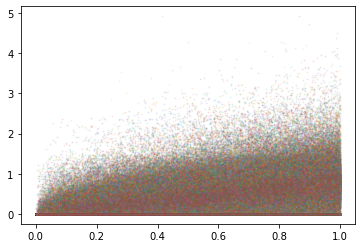

In [47]:
for ens_i in range(ens):
    plt.scatter(fitness[ens_i],slopes[ens_i],s=1,alpha=0.1)

In [12]:
r[-2:]

[([[1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    24,
    25,
    26,
    27,
    28,
    29,
    30,
    31,
    32,
    33,
    34,
    35,
    36,
    37,
    38,
    39,
    40,
    41,
    42,
    43,
    44,
    45,
    46,
    47,
    48,
    49,
    50,
    51,
    52,
    53,
    54,
    55,
    56,
    57,
    58,
    59,
    60,
    61,
    62,
    63,
    64,
    65,
    66,
    67,
    68,
    69,
    70,
    71,
    72,
    73,
    74,
    75,
    76,
    77,
    78,
    79,
    80,
    81,
    82,
    83,
    84,
    85,
    86,
    87,
    88,
    89,
    90,
    91,
    92,
    93,
    94,
    95,
    96,
    97,
    98,
    99,
    100,
    101,
    102,
    103,
    104,
    105,
    106,
    107,
    108,
    109,
    110,
    111,
    112,
    113,
    114,
    115,
    116,
    117,
    118,
    119,
    120,
    121,
    122,
    123,
 

## BianconiBarbasi Directed

In [27]:
def BianconiBarbasi_modified_trace_wonx(n=10**4,m=5,A=0,directed=False,NZ=None,show_progress=False):
    if raise_error_network(n,m,BianconiBarbasi_modified_trace_wonx.__name__):
        return False
    neiz,degree_out,L = complete_graph(n,n-m-1,return_degree=True,return_L=True)
    neiz_out = neiz.copy()
    degree_in = np.full(n,A)
    degree_in[:m+1] += m
    nrange = np.arange(n)
    degree_in_sum = m*(m+1)+(m+1)*A
    degree_in_t = np.zeros((n-m-1,n),int)
    degree_out_t = np.zeros((n-m-1,n),int)
    if NZ is None:
        NZ = 10
    if type(NZ) is int:
        NZ = np.linspace(0,n,NZ+1,endpoint=True).astype(int)
        NZ[0] = m+1
        print(NZ)
    L_t = np.zeros((len(NZ),n),int)
    m2 = m+A
    c = []
    t = 0
    for NZ_i_i,NZ_i in tqdm(enumerate(range(len(NZ)-1)),disable = not show_progress):
        for i in range(NZ[NZ_i],NZ[NZ_i+1]):
            # print(degree_in[:i+1],degree_in[:i].sum(),degree_in_sum)
            probs = (degree_in[:i])/degree_in_sum
            tolinks = np.random.choice(nrange[:i],size=m,p=probs,replace=False)
            neiz_out[i].extend(tolinks)
            ## for the perpose of calculating clustering coefficient we consider neiz to be undirected.
            for j in tolinks:
                neiz[i].append(j)
                neiz[j].append(i)
            degree_out[:i][tolinks] += 1
            degree_in[i] = m2
            degree_in_sum += m2
            degree_in_t[t] = degree_in
            degree_out_t[t] = degree_out
            t += 1
        # L_t[NZ_i_i,:NZ[NZ_i_i+1]] = calculate_L_wonx(neiz[:NZ[NZ_i_i+1]],NZ[NZ_i_i+1])
        L_t[NZ_i_i] = calculate_L_wonx(neiz)
        degree = degree_in-A + degree_out
        wh = degree <= 1
        c.append(L_t[NZ_i_i]/(degree)*(degree-1))
        c[-1][wh] = 0
    degree_in -= A
    degree_in_t -= A
    degree = degree_in + degree_out
    degree_t = degree_in_t + degree_out_t
    return neiz,degree,c,degree_t,degree_in_t,degree_out_t

In [21]:
7*6

42

In [28]:
neiz,degree,c,degree_t,degree_in_t,degree_out_t = BianconiBarbasi_modified_trace_wonx(A=2)

[    6  1000  2000  3000  4000  5000  6000  7000  8000  9000 10000]


/tmp/ipykernel_42819/3590556197.py:42: RuntimeWarning: invalid value encountered in true_divide
  c.append(L_t[NZ_i_i]/(degree)*(degree-1))


In [45]:
X,Y = histo_list(degree_in_t)

In [62]:
set(degree_in_t.flatten())

{0, 5}

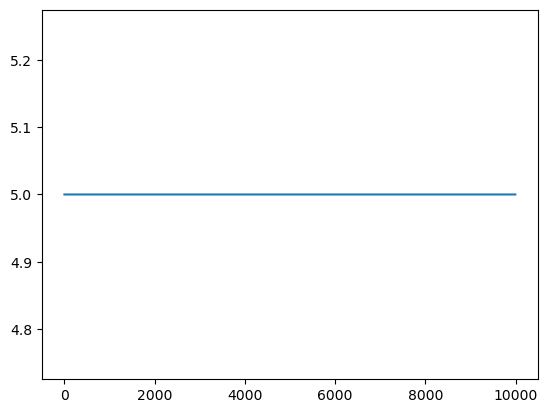

In [63]:
# plt.loglog()
plt.plot(degree_in_t.sum(1)/(np.arange(len(degree_in_t))+7))

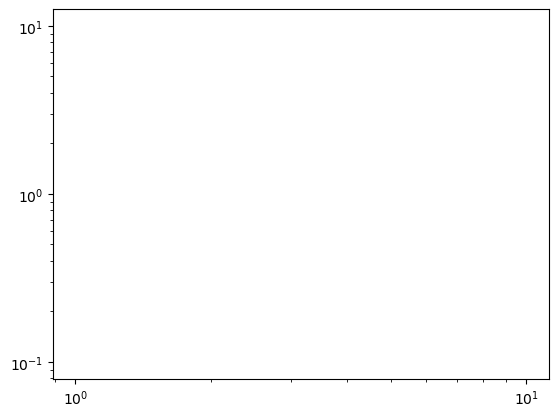

In [46]:
plt.loglog()
for i in range(len(X)):
    plt.plot(X[i],Y[i])

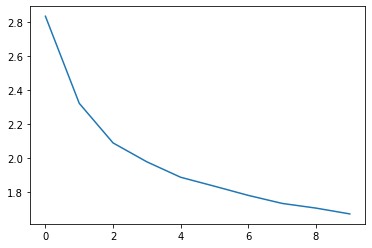

In [52]:
plt.plot([cc.sum()/(cc!=0).sum() for cc in c])

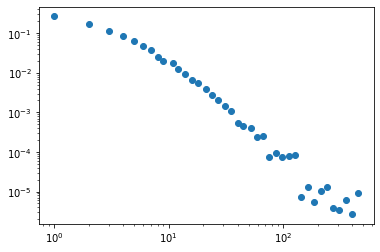

In [59]:
plt.loglog()
plt.scatter(*histo_int(degree))

In [54]:
r = complete_graph(100,4)

In [56]:
len(r[1])

100

In [86]:
Nz = np.arange(100,10**4,100)
degreez = []
c = []
degree,neiz = None,None
for n in Nz:
    degree,neiz = BianconiBarbasi_grow_wonx(degree,neiz,n=n,m=4)
    c.append(cluster_coefs(degree,neiz))
    degreez.append(degree)


100 100 100
200 200 200
300 300 300
400 400 400
500 500 500
600 600 600
700 700 700
800 800 800
900 900 900
1000 1000 1000
1100 1100 1100
1200 1200 1200
1300 1300 1300
1400 1400 1400
1500 1500 1500
1600 1600 1600
1700 1700 1700
1800 1800 1800
1900 1900 1900
2000 2000 2000
2100 2100 2100
2200 2200 2200
2300 2300 2300
2400 2400 2400
2500 2500 2500
2600 2600 2600
2700 2700 2700
2800 2800 2800
2900 2900 2900
3000 3000 3000
3100 3100 3100
3200 3200 3200
3300 3300 3300
3400 3400 3400
3500 3500 3500
3600 3600 3600
3700 3700 3700
3800 3800 3800
3900 3900 3900
4000 4000 4000
4100 4100 4100
4200 4200 4200
4300 4300 4300
4400 4400 4400
4500 4500 4500
4600 4600 4600
4700 4700 4700
4800 4800 4800
4900 4900 4900
5000 5000 5000
5100 5100 5100
5200 5200 5200
5300 5300 5300
5400 5400 5400
5500 5500 5500
5600 5600 5600
5700 5700 5700
5800 5800 5800
5900 5900 5900
6000 6000 6000
6100 6100 6100
6200 6200 6200
6300 6300 6300
6400 6400 6400
6500 6500 6500
6600 6600 6600
6700 6700 6700
6800 6800 6800
6900 69

LinregressResult(slope=-0.7552175285573799, intercept=1.9753591213216177, rvalue=-0.9990055132224783, pvalue=7.601320135128041e-133, stderr=0.0034223530693838983, intercept_stderr=0.02835198653774266)

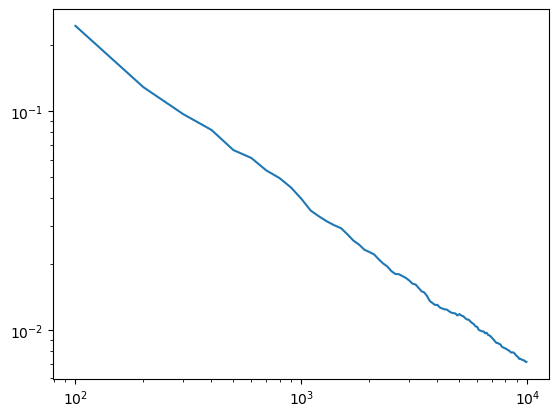

In [97]:
plt.loglog()
plt.plot(Nz,[cc.mean() for cc in c])
linregress(np.log(Nz),np.log([cc.mean() for cc in c]))

LinregressResult(slope=0.46952570212424843, intercept=1.007941355148056, rvalue=0.9992338451194896, pvalue=2.4490585746822994e-138, stderr=0.0018672241336320692, intercept_stderr=0.015468746919561677)

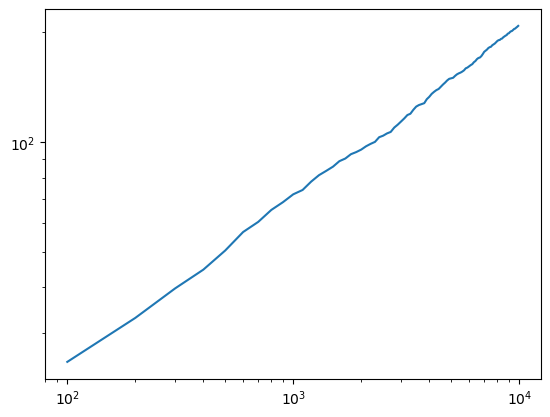

In [105]:
plt.loglog()
plt.plot(Nz,[degree[:4].mean() for degree in degreez])
linregress(np.log(Nz),np.log([degree[:4].mean() for degree in degreez]))

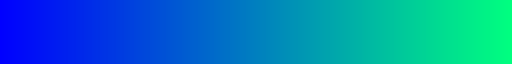

In [128]:
plt.cm.winter

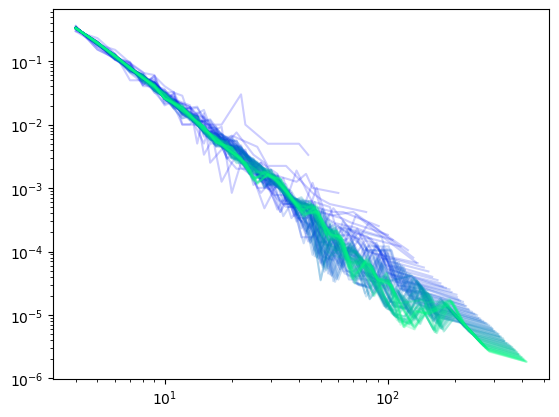

In [147]:
plt.loglog()
sl = []
color = [plt.cm.winter(i) for i in np.linspace(0,1,len(degreez))]
for i,degree in enumerate(degreez):
    z = degree
    xbin = np.unique(np.logspace(np.log10(max(z.min(),1)),np.log10(z.max()+2),50).astype(int))
    x = xbin[:-1]
    y = np.histogram(z,xbin,density=True)[0]
    nz = y!=0
    plt.plot(x[nz],y[nz],c=color[i],alpha=0.2)
    sl += [linregress(np.log(x[nz][5:-5]),np.log(y[nz][5:-5])).slope]


In [169]:
def fitter_log(x,y,ratio_score=0.5):
    if len(x) == len(y) + 1:
        x = x[:-1][y!=0]
    elif len(x) == len(y):
        x = x[y!=0]
    else:
        print("ERROR: Lenght of x must be equal to (or one more than) lenght of y in fitter_log")
        return False
    y = y[y!=0]
    x = np.log(x)
    y = np.log(y)
    if ratio_score <= 0:
        print("ERROR: ratio_Score must be between 0 and 1 in fitter_log")
        return False
    elif ratio_score >= 1:
        ratio_score = ratio_score/(ratio_score+1)
    l = len(y)
    l2 = len(y)//2
    scores = []
    for st in range(l-1):
        for en in range(st+1,l):
            scores.append([st,en,abs(linregress(x[st:en],y[st:en]).rvalue),en-st])
    return np.array(scores)
    

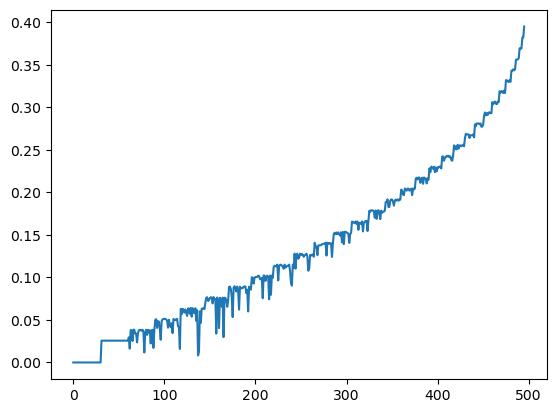

In [214]:
ff = fitter_log(x,y)
ff = ff[np.argsort(ff[:,3])]
# plt.plot(ff[:,2])
# plt.plot(ff[:,3])
plt.plot(ff[:,2]*0.5*ff[:,3]/len(x))

In [223]:
indz = []
for f1 in np.unique(ff[:,3]):
    ff2 = ff[ff[:,3]==f1]
    indz.append(np.argmax(ff2[:,2]))
zz = []
for ind in indz:
    zz.extend(list(np.arange(ff[ind,0],ff[ind,1])))

# np.histogram(ff[:,3],np.arange(ff[:,3].min(),ff[:,3].max()+2))

In [234]:
31*0.2

6.2

(array([5., 0., 0., 2., 2., 5., 1., 2., 2., 1., 0., 1., 2., 1., 0., 2., 1.,
        1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28.]),
 <BarContainer object of 28 artists>)

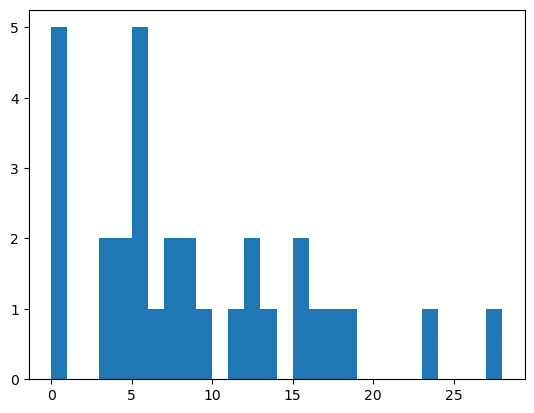

In [228]:
plt.hist(zz,np.arange(min(zz),max(zz)+2))

array([  0,  90, 118, 145, 171, 196, 220, 243, 265, 286, 306, 325, 343,
       360, 376, 391, 405, 418, 430, 441, 451, 460, 468, 475, 481, 486,
       490, 493,  61,  31, 495, 244, 476, 146, 487, 344, 361, 491, 326,
         1, 266, 419, 461, 431,  91, 442, 197,  32, 406, 119, 172, 392,
       287, 221, 307, 469, 452, 482, 494, 377,  62, 477, 327, 173, 147,
       308, 345, 245, 462, 393, 470, 378, 120,  92, 362, 407,   2, 420,
       488, 453, 267, 483,  63, 198, 492, 432, 222,  33, 443, 288, 199,
       121, 421, 394, 454, 463, 471, 379, 268, 346, 246,  34, 223, 363,
       489, 408, 289, 433, 478, 444,  64, 148, 174,  93,   3, 328, 309,
       484, 149, 455, 175, 364, 310, 380, 329, 434, 224, 247, 422,   4,
       445,  94, 290, 409,  65, 485, 395, 472, 479, 269, 464, 122, 200,
        35, 347, 423, 176,  66, 410, 270, 365,  36, 225, 435,   5, 248,
       381, 465, 201, 396, 480, 123, 291, 456,  95, 473, 150, 348, 311,
       446, 330, 349, 177, 331, 447, 466, 226,  37, 271, 424,  6

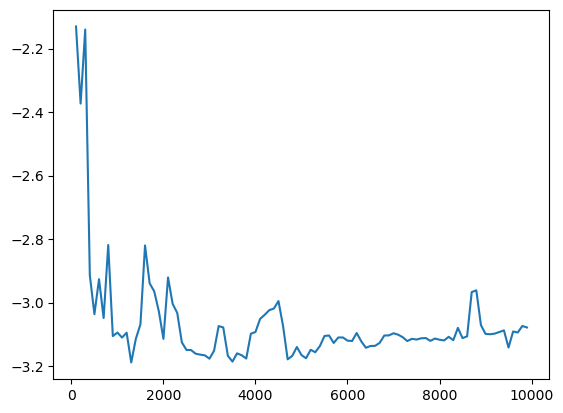

In [150]:
plt.plot(Nz,sl)

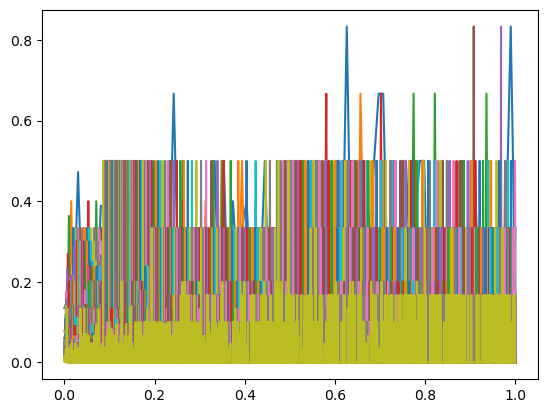

In [89]:
[plt.plot(np.linspace(0,1,len(cc)),cc) for cc in c];

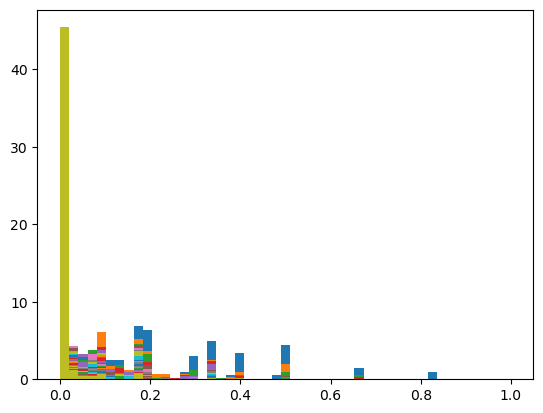

In [90]:
[plt.hist(cc,np.linspace(0,1,50),density=True) for cc in c];

In [28]:
[cc.mean() for cc in c]

[440.75582918105647, 5.171659260201283, 0.08109562785359033]

In [103]:
c1 = nx.clustering(g)

KeyboardInterrupt: 

In [104]:
r = BianconiBarbasi_trace_wonx(show_progress=1)

0it [00:00, ?it/s]

[    5  1000  2000  3000  4000  5000  6000  7000  8000  9000 10000]
5
1000


0it [08:15, ?it/s]


KeyboardInterrupt: 

In [59]:
%%timeit
a = list(np.unique(np.random.randint(0,100,20)))
b = list(np.unique(np.random.randint(0,100,10)))
len(set(a).intersection(b))

33.9 µs ± 781 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [61]:
%%timeit
a = list(np.unique(np.random.randint(0,100,20)))
b = list(np.unique(np.random.randint(0,100,10)))
len(np.intersect1d(a,b))

48 µs ± 216 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [8]:

a2 = cluster_coefs(degree,neiz)


NameError: name 'degree' is not defined

In [90]:
cluster_coefs(np.ones(5)*4,
             [list(np.delete(np.arange(5),i)) for i in range(5)]
             ,True)

1.0

In [77]:
a2.mean()

0.09542283947442785

In [67]:
%%timeit
cluster_coef(degree,neiz)

3.38 s ± 142 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [68]:
a1 = cluster_coef(degree,neiz)

In [121]:
degree,neiz = BianconiBarbasi_wonx(n=10**2)
degreez = [degree]
cluster_coefs_list = [cluster_coefs(degree,neiz)]
for i in range(3,5):
    degree,neiz = BianconiBarbasi_grow_wonx(degree,neiz,n=10**i)
    degreez.append(degree)
    cluster_coefs_list.append(cluster_coefs(degree,neiz))

LinregressResult(slope=-0.6589859974587469, intercept=0.10243110045751758, rvalue=-0.5523484390638056, pvalue=0.0012736828138217656, stderr=0.18468376211702492, intercept_stderr=0.3909876910301386)
LinregressResult(slope=-0.7893727434147321, intercept=-1.1131745802844801, rvalue=-0.6592975282592849, pvalue=4.414356847696436e-08, stderr=0.12365523846513812, intercept_stderr=0.42317649464009754)
LinregressResult(slope=-0.8438699645940481, intercept=-1.7634248348192427, rvalue=-0.7518543275237299, pvalue=3.4565672411244474e-13, stderr=0.09250265261878472, intercept_stderr=0.44857826480608537)


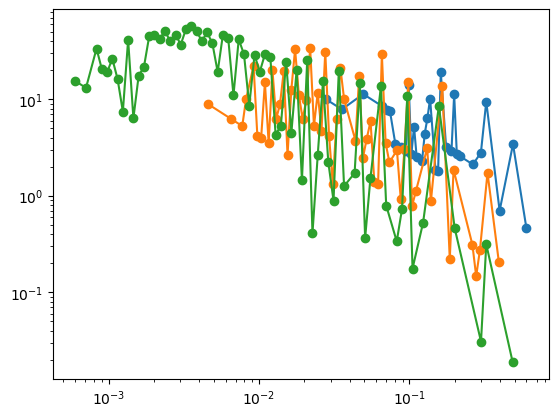

In [122]:
for i,degree in enumerate(cluster_coefs_list):
    degree = degree[degree>0].copy()
    # plt.scatter(10**(i+2),)
    # continue
    bins = np.logspace(np.log10(degree.min()),np.log10(degree.max()+1),100)
    # bins = np.linspace(degree.min(),degree.max()+2,100)
    y = np.histogram(degree,bins,density=1)[0]
    nz = y!=0
    xx = bins[:-1][nz]
    yy = y[nz]
    plt.loglog()
    plt.plot(xx,yy,'-o')
    # plt.scatter(xx,yy)
    print(linregress(np.log(xx),np.log(yy)))
    # plt.show()

LinregressResult(slope=-1.792927898784228, intercept=0.9323626271925045, rvalue=-0.9577375401065127, pvalue=1.251912825963294e-10, stderr=0.13060099145307097, intercept_stderr=0.34502853536186)
LinregressResult(slope=-2.331136184484421, intercept=1.7161366339791666, rvalue=-0.9618953881185469, pvalue=2.7018874545297657e-21, stderr=0.11200372725757145, intercept_stderr=0.35589116632767165)
LinregressResult(slope=-2.7396936953878837, intercept=2.6613482040260887, rvalue=-0.9887019363221864, pvalue=5.044540035482622e-47, stderr=0.056006977797076314, intercept_stderr=0.21695729102257436)


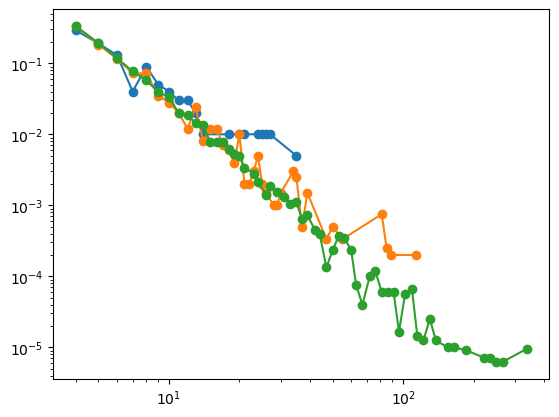

In [95]:
for degree in degreez:
    bins = np.unique(np.logspace(0,np.log10(degree.max()+1),100).astype(int))
    # bins = np.arange(degree.min(),degree.max()+2)
    y = np.histogram(degree,bins,density=1)[0]
    nz = y!=0
    xx = bins[:-1][nz]
    yy = y[nz]
    plt.loglog()
    plt.plot(xx,yy,'-o')
    # plt.scatter(xx,yy)
    print(linregress(np.log(xx),np.log(yy)))
    # plt.show()

LinregressResult(slope=-2.740548070824369, intercept=2.6471937703111434, rvalue=-0.988067556351742, pvalue=5.238509228889886e-48, stderr=0.05658399701904966, intercept_stderr=0.22147335122240241)


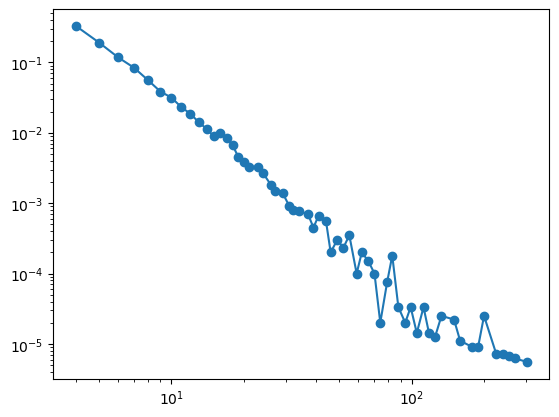

In [15]:
bins = np.unique(np.logspace(0,np.log10(degree.max()+1),100).astype(int))
y = np.histogram(degree,bins,density=True)[0]
nz = y!=0
xx = bins[:-1][nz]
yy = y[nz]
plt.loglog()
plt.plot(xx,yy,'-o')
print(linregress(np.log(xx),np.log(yy)))
# plt.show()

100%|██████████| 10000/10000 [00:01<00:00, 7763.17it/s]


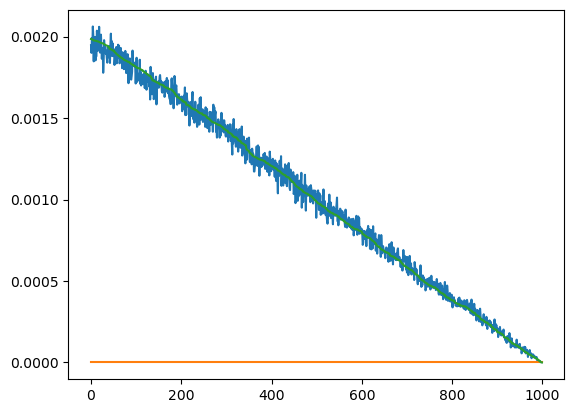

In [5]:
n = 10**3
m = 50
degs = np.random.random(n)
degs = np.sort(degs)[::-1]
nrange = np.arange(n)
q1_hist = np.zeros(n)
q2_hist = np.zeros(n)
bins = np.arange(n+1)
for ens in tqdm(range(10000)):
    probs = degs/degs.sum()
    q1 = np.random.choice(nrange,size=m,p=probs,replace=False)
    # q2 = np.zeros(m,int)
    # for i in range(m):
    #     q2[i] = np.random.choice(nrange,p=probs/probs.sum())
    #     probs[q2[i]] = 0
    q1_hist += np.histogram(q1,bins)[0]
    # q2_hist += np.histogram(q2,bins)[0]
q1_hist /= q1_hist.sum()
# q2_hist /= q2_hist.sum()
plt.plot(bins[:-1],q1_hist)
plt.plot(bins[:-1],q2_hist)
plt.plot(bins[:-1],degs/degs.sum())



LinregressResult(slope=-2.3254145906987143, intercept=0.7603547253323217, rvalue=-0.9380388249627085, pvalue=1.3648151019795739e-25, stderr=0.11912940328281123, intercept_stderr=0.4429693537025192)
LinregressResult(slope=-2.7580486063040506, intercept=4.393577931022209, rvalue=-0.992297952238377, pvalue=1.4026123072386435e-51, stderr=0.04642572812616191, intercept_stderr=0.19634604243896897)
LinregressResult(slope=-2.8588599608024086, intercept=6.489947389542506, rvalue=-0.9911236579419864, pvalue=5.76172578265583e-42, stderr=0.056539537921931185, intercept_stderr=0.27223590629088074)
LinregressResult(slope=-2.8254162702775787, intercept=7.568144347744726, rvalue=-0.991032116983268, pvalue=1.8108279841870728e-37, stderr=0.05949587886068506, intercept_stderr=0.3210524477826631)
LinregressResult(slope=-2.8392554161139967, intercept=8.410834048109141, rvalue=-0.9954005630052004, pvalue=2.529609720227004e-40, stderr=0.04432841109963776, intercept_stderr=0.2560725157079309)
LinregressResult

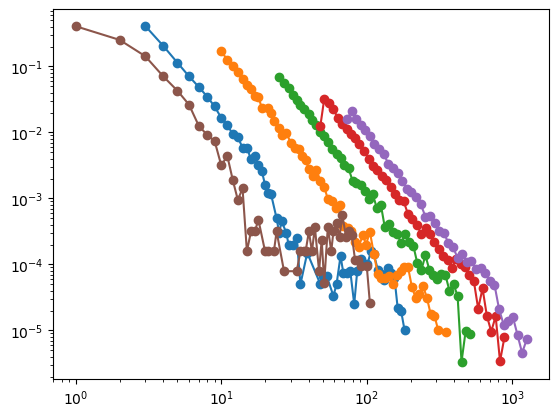

In [19]:
for m in [3,10,25,50,75,None]:
    g = BianconiBarbasi_flexible_m(m0=100,m=m,n=10000)
    degree = np.array(g.degree())[:,1]
    bins = np.unique(np.logspace(0,np.log10(degree.max()+1),100).astype(int))
    y = np.histogram(degree,bins,density=True)[0]
    nz = y!=0
    xx = bins[:-1][nz]
    yy = y[nz]
    plt.loglog()
    plt.plot(xx,yy,'-o')
    print(linregress(np.log(xx),np.log(yy)))
    # plt.show()

In [30]:
n = 10**4
m0 = 100
degez = np.zeros(n)
degez[1:m0] = np.random.randint(1,m0-1,m0-1)
degez[0] = degez[1:m0].sum()%2
m_mean = []
for i in range(m0,n):
    degez[i] += (np.random.random(i) < degez[:i]/degez[:i].sum()).sum()

In [32]:
np.random.random(i) < np.full(i,1/i)

array([False, False, False, ..., False, False, False])

In [31]:
degez[m0:].mean()

0.9934343434343434